In [1]:
import pyarrow.dataset as ds
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json

In [2]:
from statsmodels.stats import stattools
from scipy import stats
import seaborn as sns
import psutil

In [3]:
from RiskLabAI.controller import Controller
# initialize controller
controller = Controller()

In [4]:
import optuna
from optuna.samplers import TPESampler
from optuna.exceptions import TrialPruned
from optuna.samplers import QMCSampler, CmaEsSampler
import torch
print(torch.backends.mps.is_available())

True


# Load Datasets

In [5]:
#Asset under study
ticker = 'BTCUSDT'

# define dataset
dataset = ds.dataset(
    "/Users/bobet/Documents/Code Repository/Trading-Systems/_datasets",
    format="parquet")

# push filter into Arrow scan (faster, uses partition pruning if possible)
table = dataset.to_table(filter=ds.field("symbol") == ticker)

# convert to pandasssss
df = table.to_pandas()
df.tail()

,symbol,ts_ms,iso_utc,ohlc_ts_open,ohlc_open,ohlc_high,ohlc_low,ohlc_close,ohlc_volume,ohlc_ts_close,...,tr_volume_base,tr_volume_quote,tr_vwap,tr_buy_sell_imbalance,spot_price,perp_mark_price,basis_abs,basis_pct,funding_rate,next_funding_time_ms
39162,BTCUSDT,1757821722142,2025-09-14T03:48:42.142655+00:00,1757821680000,115741.99,115742.00,115729.25,115729.26,3.68421,1757821739999,...,12.22828,1.415327e+06,115742.129388,-0.359820,115729.25,115674.594917,-54.655083,-0.000472,0.000082,1757836800000
39163,BTCUSDT,1757821782162,2025-09-14T03:49:42.162661+00:00,1757821740000,115729.25,115746.27,115729.25,115746.27,2.35966,1757821799999,...,7.30407,8.453633e+05,115738.666289,0.406802,115746.27,115704.300000,-41.970000,-0.000363,0.000082,1757836800000
39164,BTCUSDT,1757821842222,2025-09-14T03:50:42.222298+00:00,1757821800000,115746.27,115746.27,115746.26,115746.26,1.97252,1757821859999,...,5.76467,6.672202e+05,115743.000526,0.167002,115746.26,115705.200271,-41.059729,-0.000355,0.000082,1757836800000
39165,BTCUSDT,1757821902272,2025-09-14T03:51:42.272630+00:00,1757821860000,115742.13,115742.13,115740.04,115740.04,1.64508,1757821919999,...,7.64589,8.849185e+05,115737.800656,-0.275776,115740.04,115688.728758,-51.311242,-0.000443,0.000082,1757836800000
39166,BTCUSDT,1757821962322,2025-09-14T03:52:42.322623+00:00,1757821920000,115740.05,115740.05,115740.04,115740.04,1.43726,1757821979999,...,8.60731,9.962008e+05,115738.920133,0.084968,115740.04,115688.258712,-51.781287,-0.000447,0.000082,1757836800000


In [6]:
#features
df.columns

Index(['symbol', 'ts_ms', 'iso_utc', 'ohlc_ts_open', 'ohlc_open', 'ohlc_high',
       'ohlc_low', 'ohlc_close', 'ohlc_volume', 'ohlc_ts_close', 'ohlc_trades',
       'ohlc_taker_base', 'ohlc_taker_quote', 'l1_bid', 'l1_ask', 'l1_mid',
       'l1_spread', 'l1_bid_qty', 'l1_ask_qty', 'l1_imbalance', 'l2_bid_depth',
       'l2_ask_depth', 'l2_depth_asymmetry', 'l2_bid_vwap', 'l2_ask_vwap',
       'l2_bid_slope', 'l2_ask_slope', 'tr_volume_base', 'tr_volume_quote',
       'tr_vwap', 'tr_buy_sell_imbalance', 'spot_price', 'perp_mark_price',
       'basis_abs', 'basis_pct', 'funding_rate', 'next_funding_time_ms'],
      dtype='object')

In [7]:
sample_size = df.count()[0]
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39167 entries, 0 to 39166
Data columns (total 37 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   symbol                 39167 non-null  object 
 1   ts_ms                  39167 non-null  int64  
 2   iso_utc                39167 non-null  object 
 3   ohlc_ts_open           39167 non-null  int64  
 4   ohlc_open              39167 non-null  float64
 5   ohlc_high              39167 non-null  float64
 6   ohlc_low               39167 non-null  float64
 7   ohlc_close             39167 non-null  float64
 8   ohlc_volume            39167 non-null  float64
 9   ohlc_ts_close          39167 non-null  int64  
 10  ohlc_trades            39167 non-null  int64  
 11  ohlc_taker_base        39167 non-null  float64
 12  ohlc_taker_quote       39167 non-null  float64
 13  l1_bid                 39167 non-null  float64
 14  l1_ask                 39167 non-null  float64
 15  l1

## Raw Features

### General
- **symbol**: Trading pair identifier (e.g., BTCUSDT).  
- **ts_ms**: Data timestamp in milliseconds (epoch time).  
- **iso_utc**: Data timestamp in human-readable UTC format.  

### OHLC Data (Candlestick)
- **ohlc_ts_open**: Opening timestamp for the candlestick period.  
- **ohlc_open**: Opening price of the candlestick.  
- **ohlc_high**: Highest price within the candlestick.  
- **ohlc_low**: Lowest price within the candlestick.  
- **ohlc_close**: Closing price of the candlestick.  
- **ohlc_volume**: Trading volume during the candlestick (base asset units).  
- **ohlc_ts_close**: Closing timestamp for the candlestick period.  
- **ohlc_trades**: Number of trades in the candlestick.  
- **ohlc_taker_base**: Base asset volume traded by takers (aggressors).  
- **ohlc_taker_quote**: Quote asset volume traded by takers.  

### Level 1 Order Book (Top of Book)
- **l1_bid**: Best bid price (highest buy order).  
- **l1_ask**: Best ask price (lowest sell order).  
- **l1_mid**: Midpoint price between bid and ask.  
- **l1_spread**: Difference between best ask and bid (ask - bid).  
- **l1_bid_qty**: Quantity available at best bid.  
- **l1_ask_qty**: Quantity available at best ask.  
- **l1_imbalance**: Order book imbalance at Level 1 = (bid_qty – ask_qty) / (bid_qty + ask_qty).  

### Level 2 Order Book (Depth of Market)
- **l2_bid_depth**: Total buy-side liquidity across multiple bid levels.  
- **l2_ask_depth**: Total sell-side liquidity across multiple ask levels.  
- **l2_depth_asymmetry**: Relative difference between bid and ask depth.  
- **l2_bid_vwap**: Volume-weighted average bid price across order book levels.  
- **l2_ask_vwap**: Volume-weighted average ask price across order book levels.  
- **l2_bid_slope**: Measure of how steeply bid prices rise with quantity (liquidity gradient).  
- **l2_ask_slope**: Measure of how steeply ask prices rise with quantity.  

### Trade Data
- **tr_volume_base**: Total traded volume in base asset.  
- **tr_volume_quote**: Total traded volume in quote asset.  
- **tr_vwap**: Trade volume-weighted average price.  
- **tr_buy_sell_imbalance**: Difference between buy-initiated and sell-initiated trade volumes.  

### Derived Prices
- **spot_price**: Current spot market price.  
- **perp_mark_price**: Mark price used in perpetual futures to avoid manipulation.  
- **basis_abs**: Absolute difference between perpetual mark price and spot price.  
- **basis_pct**: Percentage difference between perpetual mark price and spot price.  
- **funding_rate**: Periodic payment rate between long and short positions in perpetual contracts.  
- **next_funding_time_ms**: Timestamp (ms) of the next funding event.  

## Data hygiene & storage

✔ Why: storage efficiency + ordering. A 10GB dataset may shrink to ~3-4GB when optimized.

In [8]:
# Ensure correct dtypes (saves memory on 10GB dataset)
dtype_map = {
    "symbol": "category",
    "ohlc_open": "float32", "ohlc_high": "float32", "ohlc_low": "float32", "ohlc_close": "float32",
    "ohlc_volume": "float32", "ohlc_trades": "int32",
    "ohlc_taker_base": "float32", "ohlc_taker_quote": "float32",
    "l1_bid": "float32", "l1_ask": "float32", "l1_mid": "float32", "l1_spread": "float32",
    "l1_bid_qty": "float32", "l1_ask_qty": "float32", "l1_imbalance": "float32",
    "l2_bid_depth": "float32", "l2_ask_depth": "float32", "l2_depth_asymmetry": "float32",
    "l2_bid_vwap": "float32", "l2_ask_vwap": "float32",
    "l2_bid_slope": "float32", "l2_ask_slope": "float32",
    "tr_volume_base": "float32", "tr_volume_quote": "float32", "tr_vwap": "float32",
    "tr_buy_sell_imbalance": "float32",
    "spot_price": "float32", "perp_mark_price": "float32",
    "basis_abs": "float32", "basis_pct": "float32", "funding_rate": "float32"
}

df = df.astype(dtype_map)

# Make sure timestamp is datetime
df["iso_utc"] = pd.to_datetime(df["iso_utc"])
df = df.set_index("iso_utc").sort_index()


#Intergrity Check
# Drop duplicates, check ordering
df = df[~df.index.duplicated(keep="first")].sort_index()

# Sanity checks for OHLC
mask = (
    (df["ohlc_low"] <= df["ohlc_open"]) &
    (df["ohlc_low"] <= df["ohlc_close"]) &
    (df["ohlc_high"] >= df["ohlc_open"]) &
    (df["ohlc_high"] >= df["ohlc_close"])
)
df = df[mask]

# Check non-negative volumes
df = df[df["ohlc_volume"] >= 0]

## Convert DataFrame to RiskLA AI Input Format

In [9]:
df_riskAI = df.copy()
df_riskAI = df_riskAI.loc[:, ['symbol', 'ohlc_close', 'ohlc_volume']]
#rename column
df_riskAI.reset_index(inplace=True) 
df_riskAI.set_index('symbol', inplace=True)
df_riskAI.columns = ['date', 'price', 'volume']
df_riskAI.head()

,date,price,volume
symbol,,,
BTCUSDT,2025-08-17 15:45:47.575950+00:00,118251.351562,0.75580
BTCUSDT,2025-08-17 15:46:47.606265+00:00,118234.531250,5.14589
BTCUSDT,2025-08-17 15:47:47.643040+00:00,118234.531250,2.35213
BTCUSDT,2025-08-17 15:48:47.662644+00:00,118234.523438,6.03409
BTCUSDT,2025-08-17 15:49:47.702649+00:00,118234.523438,1.28289


## Load Existing Parameter Resampling Database

In [10]:
param_db_filename = 'params_resampling-scheme.json'
# Open and load JSON file

def load_param_resampling_db(file_name):
    """
    Load resampling parameter database from a JSON file.

    Parameters
    ----------
    file_name : str
        Path to the JSON file containing the parameter database.

    Returns
    -------
    list of dict
        A list of parameter dictionaries previously stored.
        If the file does not exist or is invalid, returns an empty list.

    Notes
    -----
    - The expected structure is a list of dictionaries where each dictionary
      contains keys such as 'Sampling_Scheme', 'n_trials', 'n_samples', etc.
    - Use together with `sampling_best_params` for managing optimal bar parameters.

    Examples
    --------
    >>> params_db = load_param_resampling_db("params_resampling-scheme.json")
    >>> len(params_db)
    5
    """
    with open(file_name, "r") as f:
        df_params = json.load(f)
    return df_params

db_resampling_params = load_param_resampling_db(param_db_filename)
db_resampling_params

[{'ticker': 'BTCUSDT',
  'time_frame': '1m',
  'Sampling_Scheme': 'expected_tick_imbalance_bars',
  'n_trials': 50,
  'n_samples': 39167,
  'batch_size': 30275161,
  'Shapiro-Wilk_statistic': 0,
  'Shapiro-Wilk_pvalue': 0,
  'window_size_for_expected_n_ticks_estimation': 5,
  'window_size_for_expected_imbalance_estimation': 2000,
  'initial_estimate_of_expected_n_ticks_in_bar': 50},
 {'ticker': 'BTCUSDT',
  'time_frame': '1m',
  'Sampling_Scheme': 'expected_volume_imbalance_bars',
  'n_trials': 50,
  'n_samples': 39167,
  'batch_size': 30275161,
  'Shapiro-Wilk_statistic': 0,
  'Shapiro-Wilk_pvalue': 0,
  'window_size_for_expected_n_ticks_estimation': 5,
  'window_size_for_expected_imbalance_estimation': 2000,
  'initial_estimate_of_expected_n_ticks_in_bar': 50},
 {'ticker': 'BTCUSDT',
  'time_frame': '1m',
  'Sampling_Scheme': 'expected_dollar_imbalance_bars',
  'n_trials': 50,
  'n_samples': 39167,
  'batch_size': 30275161,
  'Shapiro-Wilk_statistic': 0,
  'Shapiro-Wilk_pvalue': 0,
 

In [11]:
# df_param = pd.DataFrame(db_resampling_params)

# df_param.to_csv("params_resampling-scheme.csv")

In [12]:
# # Load CSV
# csv_file = "params_resampling-scheme.csv"
# df = pd.read_csv(csv_file)

# # Convert to JSON
# json_file = csv_file.replace(".csv", ".json")
# df.to_json(json_file, orient="records", indent=4)

# print(f"Saved JSON to {json_file}")

In [13]:
#load best parameters in the resampling database
def db_resampling_best_params(_sampling_method,db_params):
    """
    Retrieve the best parameter set for a given resampling method
    from the parameter database.

    Parameters
    ----------
    _sampling_method : str
        The sampling scheme to filter on, e.g.:
        - "expected_tick_imbalance_bars"
        - "expected_volume_run_bars"
    db_params : list of dict
        The resampling parameter database, typically loaded from JSON.

    Returns
    -------
    dict
        The best parameter dictionary for the given sampling scheme.

    Notes
    -----
    - Ranking is based on three criteria:
        1. `n_samples` (ascending) → prefer larger sample size.
        2. `Shapiro-Wilk_pvalue` (ascending).
        3. `Shapiro-Wilk_statistic` (ascending).
    - The last row after sorting is returned (`tail(1)`), so effectively it picks 
      the parameters with *highest* sample size, *highest* p-value, and *highest* statistic.

    Examples
    --------
    >>> best = db_resampling_best_params("expected_tick_imbalance_bars", params_db)
    >>> best["n_samples"]
    25000
    """
    db = pd.DataFrame(db_params)
    db = db.loc[db['Sampling_Scheme'] ==_sampling_method]

    # Sort by 'n_samples' first, then by 'Shapiro-Wilk_pvalue', then by 'Shapiro-Wilk_statistic'
    db = db.sort_values(
        by=['n_samples', 'Shapiro-Wilk_pvalue', 'Shapiro-Wilk_statistic'],
        ascending=[True, True, True])   # example: n_samples ↑, pvalue ↓, stat ↓

    return db.tail(1).to_dict(orient="records")[0]

In [14]:
db_best_params = db_resampling_best_params(_sampling_method='expected_dollar_imbalance_bars',db_params=db_resampling_params)
db_best_params

{'ticker': 'BTCUSDT',
 'time_frame': '1m',
 'Sampling_Scheme': 'expected_dollar_imbalance_bars',
 'n_trials': 50,
 'n_samples': 39167,
 'batch_size': 30275161,
 'Shapiro-Wilk_statistic': 0,
 'Shapiro-Wilk_pvalue': 0,
 'window_size_for_expected_n_ticks_estimation': 5,
 'window_size_for_expected_imbalance_estimation': 2000,
 'initial_estimate_of_expected_n_ticks_in_bar': 50}

# Utilily Functions

## Helper Functions

Summed (additive counts / volumes)

We sum over the ticks inside each bar:
	•	ohlc_trades
	•	ohlc_taker_base
	•	ohlc_taker_quote
	•	tr_volume_base
	•	tr_volume_quote

⸻

Last (state-like snapshots, take the latest tick in the bar)

We forward-fill within the bar only, then take the last available value:
	•	l1_bid, l1_ask, l1_mid, l1_spread
	•	l1_bid_qty, l1_ask_qty, l1_imbalance
	•	l2_bid_depth, l2_ask_depth, l2_depth_asymmetry
	•	l2_bid_vwap, l2_ask_vwap, l2_bid_slope, l2_ask_slope
	•	spot_price, perp_mark_price
	•	basis_abs, basis_pct
	•	funding_rate, next_funding_time_ms

(These are “levels” or “state variables” you’d want at the bar close.)

⸻

Mean (averaged inside the bar)
	•	tr_buy_sell_imbalance

⸻

Weighted mean (value × volume / total volume)
	•	tr_vwap (weighted by tr_volume_base)

(This is the standard definition of VWAP: average trade price weighted by base-asset volume.)

In [15]:
#Compute log returns from a price series.l
log_return = lambda s: np.log(s).diff().dropna()

# Hyper Parameter Optimization with Optuna

## Optimization_Helper Function

In [16]:
def _batch_size(df_raw):
    # Load a small sample of your data
    df_batch = df_raw.head(10000)  # or CSV, etc.

    # Estimate memory usage per row
    bytes_per_row = df_batch.memory_usage(deep=True).sum() / len(df_batch)

    # Get available RAM (bytes)
    avail_ram = psutil.virtual_memory().available

    # Budget: use only 30% of available RAM to be safe
    ram_budget = 0.3 * avail_ram

    # Rough batch size estimate
    batch_size = int(ram_budget / bytes_per_row)

    print(f"Bytes per row ≈ {bytes_per_row:.1f}")
    print(f"Available RAM ≈ {avail_ram/1e9:.1f} GB")
    print(f"Safe batch_size ≈ {batch_size:,} rows")

    return batch_size

In [17]:
def sampling_seach_space_parameter(input_df: pd.DataFrame) -> dict:
    """
    Classify irregular DatetimeIndex into timeframe bucket & trading style
    by using the median difference between consecutive timestamps.
    """
    if not isinstance(input_df.index, pd.DatetimeIndex):
        raise ValueError("DataFrame index must be a DatetimeIndex")
    
    # Compute median difference in seconds
    diffs = input_df.index.to_series().diff().dropna().dt.total_seconds()
    median_sec = diffs.median()
    
    # Convert to minutes
    minutes = median_sec / 60.0
    
    # Grid search for different trading styles

    scalper = {
        "wn":   [5, 10, 15],                 # window_size_for_expected_n_ticks_estimation
        "wi":   [1_000, 2_500, 5_000],     # window_size_for_expected_imbalance_estimation
        "seed": [50, 150],      # initial_estimate_of_expected_n_ticks_in_bar
    }

    day_trader = {
        "wn":   [10, 20, 30],
        "wi":   [5_000, 10_000, 20_000],
        "seed": [2_000, 10_000, 20_000],
    }

    swing_trader = {
        "wn":   [30, 50, 80],
        "wi":   [15_000, 30_000, 60_000],
        "seed": [10_000, 30_000, 60_000],
    }

    position_trader = {
        "wn":   [50, 80, 100],
        "wi":   [30_000, 80_000, 120_000],
        "seed": [20_000, 80_000, 120_000],
    }

    # Classification
    if minutes <= 5:
        bucket = f"{round(minutes)}m"
        style = "Scalper"
        search_space = scalper
    elif 10 <= minutes <= 60:
        bucket = f"{round(minutes)}m–1h"
        style = "Day trader"
        search_space = day_trader 
    elif 240 <= minutes <= 1440:
        bucket = f"{round(minutes/60)}h–1d"
        style = "Swing trader"
        search_space = swing_trader
    elif minutes >= 10080:  # 7 days
        bucket = "1w+"
        style = "Position trader"
        search_space =  position_trader
    else:
        bucket = f"{minutes:.1f}m"
        style = "Unclassified"
    
    return {
        "median_interval_min": minutes,
        "bucket": bucket,
        "style": style,
        "grid_search": search_space} 

In [18]:
# pip install pyswarms
import json
import numpy as np
from scipy import stats
import pyswarms as ps  # PSO

# ---------- retention penalty ----------
def penalty(raw_df, sampling_output):
    """
    Penalize retention outside [0.15, 0.50].
    Returns (penalty, retention_ratio).
    """
    retention_ratio = len(sampling_output) / max(1, len(raw_df))
    if retention_ratio < 0.15:
        pen = (0.15 - retention_ratio) * 10
    elif retention_ratio > 0.50:
        pen = (retention_ratio - 0.50) * 10
    else:
        pen = 0.0
    return pen, retention_ratio


def sampling_best_params(
    sampling_method,
    df_sample,
    params_resampling_db,
    db_file_name,
    chunk_size,
    trials=50,              # total PSO iterations budget
    time_frame_label="1m",
    n_particles=24,         # swarm size
    seed=123,
    n_restarts=3,           # <-- anti-local-minima: number of restarts
    stagnation_patience=10, # iters with no improv before triggering a restart
    stagnation_tol=1e-6,    # min improvement to count as progress
):
    """
    Tune hyperparameters for imbalance/run bar sampling using
    Shapiro–Wilk (maximize stat => minimize 1 - stat) + retention penalty,
    optimized by Particle Swarm Optimization (PySwarms) with multi-restarts to
    escape local minima.
    """

    rng = np.random.default_rng(seed)
    n = len(df_sample)

    # --------- search ranges ----------
    wn_range   = (1, 2_000)                           # window_size_for_expected_n_ticks_estimation
    wi_range   = (10, min(20_000, max(500, n // 10)))  # window_size_for_expected_imbalance_estimation
    seed_range = (10, 1_000)                             # initial_estimate_of_expected_n_ticks_in_bar

    # Optimize in log10 space; convert back to ints when evaluating
    lb = np.log10([wn_range[0],  wi_range[0],  seed_range[0]]).astype(float)
    ub = np.log10([wn_range[1],  wi_range[1],  seed_range[1]]).astype(float)
    bounds = (lb, ub)

    # --------- preload existing best from DB (if any) ----------
    try:
        _db_best_params = db_resampling_best_params(
            _sampling_method=sampling_method,
            db_params=params_resampling_db,
        )
    except Exception:
        _db_best_params = None

    # --------- persist helper ----------
    def _save_to_db(_new_params: dict):
        params_resampling_db.append(_new_params)
        with open(db_file_name, "w") as f:
            json.dump(params_resampling_db, f, indent=4)

    # --------- selection helper ----------
    def _output(_old_param, _new_param, param_db, sample_size):
        if _old_param is None:
            _save_to_db(_new_param); return _new_param
        if _new_param in param_db:
            print("⚠️ Already exists."); return _old_param
        if _new_param.get("Shapiro-Wilk_pvalue") is None:
            print("ℹ️ Invalid trial, keeping existing best."); return _old_param
        if sample_size > _old_param.get("n_samples", 0):
            _save_to_db(_new_param); print("✅ Larger sample size, updated."); return _new_param
        if (sample_size == _old_param.get("n_samples", 0)
            and _new_param["Shapiro-Wilk_pvalue"] > _old_param.get("Shapiro-Wilk_pvalue", -1)):
            _save_to_db(_new_param); print("🔄 Same sample size, better Shapiro p-value, updated."); return _new_param
        else:
        #print("ℹ️ Did not satisfy update conditions — keeping existing best."); return _old_param
            print("ℹ️ Did not satisfy update conditions — replacing with best params"); _save_to_db(_new_param);return _new_param

    # --------- objective (minimize) ----------
    BIG = 1e12  # penalty for infeasible configs

    def _shapiro_loss_and_attrs(rets):
        """Return (loss, stat, pval). Loss = (1 - stat); subsample if >5000."""
        if rets.size > 5000:
            # cap sample size for numerical stability; vary seed slightly across calls
            rloc = rng.integers(0, 1_000_000)
            idx = np.random.default_rng(rloc).choice(rets.size, size=5000, replace=False)
            sample = rets[idx]
        else:
            sample = rets
        try:
            stat, pval = stats.shapiro(sample)
        except Exception:
            return 1, 0, 0
        
        # Replace None with 0
        if stat is None:
            stat = 0.0
        if pval is None:
            pval = 0.0
        # Compute loss = 1 - stat
        loss = float(1.0 - stat)
        return loss, float(stat), float(pval)

    def _eval_single(log_params):
        # log10 -> integer hyperparams within bounds
        wn  = int(np.clip(round(10 ** log_params[0]), wn_range[0], wn_range[1]))
        wi  = int(np.clip(round(10 ** log_params[1]), wi_range[0], wi_range[1]))
        seed_ticks = int(np.clip(round(10 ** log_params[2]), seed_range[0], seed_range[1]))

        # Feasibility constraints (soft penalties)
        if wi < 2 * wn:
            return BIG
        if seed_ticks > 5 * wn:
            return BIG

        try:
            bars = controller.handle_input_command(
                method_name=sampling_method,
                method_arguments={
                    "window_size_for_expected_n_ticks_estimation": wn,
                    "window_size_for_expected_imbalance_estimation": wi,
                    "initial_estimate_of_expected_n_ticks_in_bar": seed_ticks,
                },
                input_data=df_sample,
                batch_size=chunk_size,
            )
        except Exception:
            return BIG  # failed build

        # Enough bars?
        min_bars = max(200, n // 200)
        if len(bars) < min_bars:
            return BIG

        # Returns
        close_col = "Close" if "Close" in bars.columns else bars.columns[-1]
        rets = np.diff(np.log(bars[close_col].astype(float).to_numpy()))
        rets = rets[np.isfinite(rets)]
        if rets.size < 3 or np.var(rets) <= 1e-12:
            return BIG

        # Shapiro loss + retention penalty
        loss_norm, stat, _ = _shapiro_loss_and_attrs(rets)
        if stat is None:
            return BIG
        ret_pen, _ = penalty(df_sample, bars)

        return float(loss_norm) + float(ret_pen)

    def pso_objective(X):
        # X: (n_particles, dim)
        return np.array([_eval_single(row) for row in X], dtype=float)

    # --------- multi-restart PSO (anti-local-minima) ----------
    iters_per_restart = max(1, trials // max(1, n_restarts))
    best_cost_overall = np.inf
    best_pos_overall = None

    # base init positions (random)
    base_init = rng.uniform(low=lb, high=ub, size=(n_particles, 3))

    # if DB best exists, seed particle 0 with it
    if _db_best_params is not None:
        try:
            seed_vec = np.log10([
                np.clip(int(_db_best_params["window_size_for_expected_n_ticks_estimation"]), *wn_range),
                np.clip(int(_db_best_params["window_size_for_expected_imbalance_estimation"]), *wi_range),
                np.clip(int(_db_best_params["initial_estimate_of_expected_n_ticks_in_bar"]), *seed_range),
            ])
            base_init[0] = np.clip(seed_vec, lb, ub)
        except Exception:
            pass
    else:
        # center seed
        mid_vec = np.log10([
            (wn_range[0] + wn_range[1]) / 2,
            (wi_range[0] + wi_range[1]) / 2,
            (seed_range[0] + seed_range[1]) / 2,
        ])
        base_init[0] = np.clip(mid_vec, lb, ub)

    options = dict(c1=0.5, c2=0.3, w=0.9)

    for r in range(n_restarts):
        # for restart r>0: re-seed around best-so-far with Gaussian jitter in log-space
        if r == 0 or best_pos_overall is None:
            init_pos = base_init.copy()
        else:
            jitter = rng.normal(loc=0.0, scale=0.15, size=(n_particles, 3))  # 0.15 ~ ~10^0.15≈1.41x
            init_pos = np.clip(best_pos_overall + jitter, lb, ub)
            init_pos[0] = np.clip(best_pos_overall, lb, ub)  # keep one exact best

        optimizer = ps.single.GlobalBestPSO(
            n_particles=n_particles,
            dimensions=3,
            options=options,
            bounds=bounds,
            init_pos=init_pos,
            ftol=stagnation_tol,     # stagnation tolerance
            ftol_iter=stagnation_patience,  # patience
        )

        cost, pos = optimizer.optimize(pso_objective, iters=iters_per_restart, verbose=True)

        if cost < best_cost_overall - stagnation_tol:
            best_cost_overall, best_pos_overall = cost, pos
        else:
            # If no improvement this restart, increase exploration next time
            options["w"] = max(0.6, options["w"] * 0.95)   # slight inertia decay
            options["c1"] = min(1.2, options["c1"] + 0.05) # more self-exploration

    # --------- evaluate best solution to collect metrics ----------
    def _transform_and_eval(log_params):
        wn  = int(np.clip(round(10 ** log_params[0]), wn_range[0], wn_range[1]))
        wi  = int(np.clip(round(10 ** log_params[1]), wi_range[0], wi_range[1]))
        seed_ticks = int(np.clip(round(10 ** log_params[2]), seed_range[0], seed_range[1]))

        bars = controller.handle_input_command(
            method_name=sampling_method,
            method_arguments={
                "window_size_for_expected_n_ticks_estimation": wn,
                "window_size_for_expected_imbalance_estimation": wi,
                "initial_estimate_of_expected_n_ticks_in_bar": seed_ticks,
            },
            input_data=df_sample,
            batch_size=chunk_size,
        )

        close_col = "Close" if "Close" in bars.columns else bars.columns[-1]
        rets = np.diff(np.log(bars[close_col].astype(float).to_numpy()))
        rets = rets[np.isfinite(rets)]

        # Shapiro metrics for reporting (use same subsample cap)
        loss_norm, stat, pval = _shapiro_loss_and_attrs(rets)
        ret_pen, ratio = penalty(df_sample, bars)

        total_loss = float(loss_norm) + float(ret_pen)

        return dict(
            wn=wn, wi=wi, seed_ticks=seed_ticks,
            shapiro_stat=float(stat),
            shapiro_pval=float(pval),
            retention_ratio=float(ratio),
            loss=total_loss,
        )

    best_metrics = _transform_and_eval(best_pos_overall)
    sample_size = len(df_sample)

    new_params = {
        "ticker": df_sample.index.unique()[0],
        "time_frame": time_frame_label,
        "Sampling_Scheme": sampling_method,
        "n_trials": trials,
        "n_samples": sample_size,
        "batch_size": chunk_size,
        "Shapiro-Wilk_statistic": best_metrics["shapiro_stat"],
        "Shapiro-Wilk_pvalue": best_metrics["shapiro_pval"],
        "retention_ratio": best_metrics["retention_ratio"],
        "window_size_for_expected_n_ticks_estimation": best_metrics["wn"],
        "window_size_for_expected_imbalance_estimation": best_metrics["wi"],
        "initial_estimate_of_expected_n_ticks_in_bar": best_metrics["seed_ticks"],
    }

    chosen = _output(
        _old_param=_db_best_params,
        _new_param=new_params,
        param_db=params_resampling_db,
        sample_size=sample_size,
    )
    return chosen

## Optimized Sampling Schemes Parameters

### Optimized Imbalance Bars

In [19]:
max_batch_size = _batch_size(df_raw=df)

Bytes per row ≈ 165.0
Available RAM ≈ 18.2 GB
Safe batch_size ≈ 33,165,206 rows


In [20]:
n_trials = 100
n_pat = 60

##### Imbalance Tick Bars Parameters

In [21]:
params_expected_tick_bars = sampling_best_params(sampling_method='expected_tick_imbalance_bars', 
                                                df_sample=df_riskAI, 
                                                params_resampling_db=db_resampling_params, 
                                                db_file_name=param_db_filename ,                                                
                                                chunk_size = max_batch_size , 
                                                trials=n_trials, 
                                                n_particles=n_pat,
                                                time_frame_label="1m"
)

params_expected_tick_bars

2025-09-16 08:06:22,811 - pyswarms.single.global_best - INFO - Optimize for 33 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/33

Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167


pyswarms.single.global_best:   3%|▎         |1/33, best_cost=4.96

Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167


pyswarms.single.global_best:   6%|▌         |2/33, best_cost=4.9 

Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167


pyswarms.single.global_best:   9%|▉         |3/33, best_cost=4.66

Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167


pyswarms.single.global_best:  12%|█▏        |4/33, best_cost=4.31

Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167


pyswarms.single.global_best:  15%|█▌        |5/33, best_cost=4.31

Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167


pyswarms.single.global_best:  18%|█▊        |6/33, best_cost=4.31

Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167


pyswarms.single.global_best:  21%|██        |7/33, best_cost=4.31

Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167


pyswarms.single.global_best:  24%|██▍       |8/33, best_cost=4.31

Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167


pyswarms.single.global_best:  27%|██▋       |9/33, best_cost=4.31

Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 w

pyswarms.single.global_best:  30%|███       |10/33, best_cost=4.31

Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167


pyswarms.single.global_best:  33%|███▎      |11/33, best_cost=4.17

Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 w

pyswarms.single.global_best:  36%|███▋      |12/33, best_cost=3.85

Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 w

pyswarms.single.global_best:  39%|███▉      |13/33, best_cost=3.85

Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167


pyswarms.single.global_best:  42%|████▏     |14/33, best_cost=3.85

Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167


pyswarms.single.global_best:  45%|████▌     |15/33, best_cost=3.85

Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167


pyswarms.single.global_best:  48%|████▊     |16/33, best_cost=3.59

Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167


pyswarms.single.global_best:  52%|█████▏    |17/33, best_cost=3.59

Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167


pyswarms.single.global_best:  55%|█████▍    |18/33, best_cost=3.59

Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 w

pyswarms.single.global_best:  58%|█████▊    |19/33, best_cost=3.59

Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167


pyswarms.single.global_best:  61%|██████    |20/33, best_cost=3.59

Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 w

pyswarms.single.global_best:  64%|██████▎   |21/33, best_cost=3.59

Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 w

pyswarms.single.global_best:  67%|██████▋   |22/33, best_cost=3.59

Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 w

pyswarms.single.global_best:  70%|██████▉   |23/33, best_cost=3.59

Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167


pyswarms.single.global_best:  73%|███████▎  |24/33, best_cost=3.59

Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167


pyswarms.single.global_best:  76%|███████▌  |25/33, best_cost=3.59

Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 w

pyswarms.single.global_best:  76%|███████▌  |25/33, best_cost=3.59
2025-09-16 08:24:49,505 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 3.587542396758111, best pos: [2.07287783 3.22972625 2.49297155]
2025-09-16 08:24:49,510 - pyswarms.single.global_best - INFO - Optimize for 33 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/33

Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 w

pyswarms.single.global_best:   3%|▎         |1/33, best_cost=3.02

Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167


pyswarms.single.global_best:   6%|▌         |2/33, best_cost=3.02

Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167


pyswarms.single.global_best:   9%|▉         |3/33, best_cost=3.02

Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167


pyswarms.single.global_best:  12%|█▏        |4/33, best_cost=3.02

Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167


pyswarms.single.global_best:  15%|█▌        |5/33, best_cost=2.17

Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167


pyswarms.single.global_best:  18%|█▊        |6/33, best_cost=2.17

Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167


pyswarms.single.global_best:  21%|██        |7/33, best_cost=2.17

Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167


pyswarms.single.global_best:  24%|██▍       |8/33, best_cost=2.17

Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167


pyswarms.single.global_best:  27%|██▋       |9/33, best_cost=2.17

Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167


pyswarms.single.global_best:  30%|███       |10/33, best_cost=2.17

Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 w

pyswarms.single.global_best:  33%|███▎      |11/33, best_cost=2.17

Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 w

pyswarms.single.global_best:  36%|███▋      |12/33, best_cost=2.17

Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 w

pyswarms.single.global_best:  39%|███▉      |13/33, best_cost=2.17

Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 w

pyswarms.single.global_best:  42%|████▏     |14/33, best_cost=2.17

Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 w

pyswarms.single.global_best:  42%|████▏     |14/33, best_cost=2.17
2025-09-16 08:37:55,439 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 2.1746534481106288, best pos: [2.07904739 3.16982778 2.52334725]
2025-09-16 08:37:55,443 - pyswarms.single.global_best - INFO - Optimize for 33 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/33

Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 w

pyswarms.single.global_best:   3%|▎         |1/33, best_cost=1.89

Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167


pyswarms.single.global_best:   6%|▌         |2/33, best_cost=1.89

Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167


pyswarms.single.global_best:   9%|▉         |3/33, best_cost=1.89

Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167


pyswarms.single.global_best:  12%|█▏        |4/33, best_cost=1.89

Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167


pyswarms.single.global_best:  15%|█▌        |5/33, best_cost=1.89

Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167


pyswarms.single.global_best:  18%|█▊        |6/33, best_cost=1.89

Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167


pyswarms.single.global_best:  21%|██        |7/33, best_cost=1.89

Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167


pyswarms.single.global_best:  24%|██▍       |8/33, best_cost=1.89

Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167


pyswarms.single.global_best:  27%|██▋       |9/33, best_cost=1.89

Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167


pyswarms.single.global_best:  30%|███       |10/33, best_cost=1.89

Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167


pyswarms.single.global_best:  30%|███       |10/33, best_cost=1.89
2025-09-16 08:46:35,656 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1.8877152576504237, best pos: [2.07904739 3.16982778 2.52334725]


Processing batch 0 with size 39167
ℹ️ Did not satisfy update conditions — replacing with best params


{'ticker': 'BTCUSDT',
 'time_frame': '1m',
 'Sampling_Scheme': 'expected_tick_imbalance_bars',
 'n_trials': 100,
 'n_samples': 39167,
 'batch_size': 33165206,
 'Shapiro-Wilk_statistic': 0.5167859196662903,
 'Shapiro-Wilk_pvalue': 0.0,
 'retention_ratio': 0.6802665509229708,
 'window_size_for_expected_n_ticks_estimation': 120,
 'window_size_for_expected_imbalance_estimation': 1479,
 'initial_estimate_of_expected_n_ticks_in_bar': 334}

##### Imbalance Volume Bars Parameters

In [22]:
params_expected_volume_bars = sampling_best_params(sampling_method='expected_volume_imbalance_bars', 
                                                df_sample=df_riskAI, 
                                                params_resampling_db=db_resampling_params, 
                                                db_file_name=param_db_filename,
                                                chunk_size = max_batch_size , 
                                                trials=n_trials, 
                                                n_particles=n_pat,
                                                time_frame_label="1m"
)

params_expected_volume_bars

2025-09-16 08:46:37,050 - pyswarms.single.global_best - INFO - Optimize for 33 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/33

Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167


pyswarms.single.global_best:   3%|▎         |1/33, best_cost=2.42

Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167


pyswarms.single.global_best:   6%|▌         |2/33, best_cost=2.04

Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167


pyswarms.single.global_best:   9%|▉         |3/33, best_cost=2.04

Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 w

pyswarms.single.global_best:  12%|█▏        |4/33, best_cost=2.04

Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 w

pyswarms.single.global_best:  15%|█▌        |5/33, best_cost=2.04

Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 w

pyswarms.single.global_best:  18%|█▊        |6/33, best_cost=0.638

Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167


pyswarms.single.global_best:  21%|██        |7/33, best_cost=0.638

Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167


pyswarms.single.global_best:  24%|██▍       |8/33, best_cost=0.338

Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167


pyswarms.single.global_best:  27%|██▋       |9/33, best_cost=0.338

Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 w

pyswarms.single.global_best:  30%|███       |10/33, best_cost=0.338

Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 w

pyswarms.single.global_best:  33%|███▎      |11/33, best_cost=0.338

Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 w

pyswarms.single.global_best:  36%|███▋      |12/33, best_cost=0.338

Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 w

pyswarms.single.global_best:  39%|███▉      |13/33, best_cost=0.338

Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 w

pyswarms.single.global_best:  42%|████▏     |14/33, best_cost=0.338

Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 w

pyswarms.single.global_best:  45%|████▌     |15/33, best_cost=0.338

Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 w

pyswarms.single.global_best:  48%|████▊     |16/33, best_cost=0.338

Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167


pyswarms.single.global_best:  52%|█████▏    |17/33, best_cost=0.338

Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167


pyswarms.single.global_best:  52%|█████▏    |17/33, best_cost=0.338
2025-09-16 08:53:42,691 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.33810603618621826, best pos: [1.10208179 2.10433817 1.19490726]
2025-09-16 08:53:42,695 - pyswarms.single.global_best - INFO - Optimize for 33 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


Processing batch 0 with size 39167


pyswarms.single.global_best:   0%|          |0/33

Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 w

pyswarms.single.global_best:   3%|▎         |1/33, best_cost=0.118

Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 w

pyswarms.single.global_best:   6%|▌         |2/33, best_cost=0.118

Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 w

pyswarms.single.global_best:   9%|▉         |3/33, best_cost=0.118

Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 w

pyswarms.single.global_best:  12%|█▏        |4/33, best_cost=0.118

Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 w

pyswarms.single.global_best:  15%|█▌        |5/33, best_cost=0.118

Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 w

pyswarms.single.global_best:  18%|█▊        |6/33, best_cost=0.118

Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167


pyswarms.single.global_best:  21%|██        |7/33, best_cost=0.118

Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167


pyswarms.single.global_best:  24%|██▍       |8/33, best_cost=0.118

Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167


pyswarms.single.global_best:  27%|██▋       |9/33, best_cost=0.118

Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 w

pyswarms.single.global_best:  30%|███       |10/33, best_cost=0.118

Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167


pyswarms.single.global_best:  33%|███▎      |11/33, best_cost=0.1  

Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167


pyswarms.single.global_best:  36%|███▋      |12/33, best_cost=0.1

Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 w

pyswarms.single.global_best:  39%|███▉      |13/33, best_cost=0.1

Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 w

pyswarms.single.global_best:  42%|████▏     |14/33, best_cost=0.1

Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 w

pyswarms.single.global_best:  45%|████▌     |15/33, best_cost=0.1

Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 w

pyswarms.single.global_best:  48%|████▊     |16/33, best_cost=0.1

Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 w

pyswarms.single.global_best:  52%|█████▏    |17/33, best_cost=0.1

Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 w

pyswarms.single.global_best:  55%|█████▍    |18/33, best_cost=0.1

Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 w

pyswarms.single.global_best:  58%|█████▊    |19/33, best_cost=0.1

Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 w

pyswarms.single.global_best:  61%|██████    |20/33, best_cost=0.1

Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 w

pyswarms.single.global_best:  61%|██████    |20/33, best_cost=0.1
2025-09-16 08:58:57,259 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.10042858123779297, best pos: [1.17310686 2.05456012 1.28254801]
2025-09-16 08:58:57,263 - pyswarms.single.global_best - INFO - Optimize for 33 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/33

Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 w

pyswarms.single.global_best:   3%|▎         |1/33, best_cost=0.245

Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 w

pyswarms.single.global_best:   6%|▌         |2/33, best_cost=0.245

Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 w

pyswarms.single.global_best:   9%|▉         |3/33, best_cost=0.245

Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 w

pyswarms.single.global_best:  12%|█▏        |4/33, best_cost=0.245

Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 w

pyswarms.single.global_best:  15%|█▌        |5/33, best_cost=0.245

Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 w

pyswarms.single.global_best:  18%|█▊        |6/33, best_cost=0.245

Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167


pyswarms.single.global_best:  21%|██        |7/33, best_cost=0.245

Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167


pyswarms.single.global_best:  24%|██▍       |8/33, best_cost=0.23 

Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167


pyswarms.single.global_best:  27%|██▋       |9/33, best_cost=0.23

Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 w

pyswarms.single.global_best:  30%|███       |10/33, best_cost=0.23

Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 w

pyswarms.single.global_best:  33%|███▎      |11/33, best_cost=0.23

Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 w

pyswarms.single.global_best:  36%|███▋      |12/33, best_cost=0.23

Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 w

pyswarms.single.global_best:  39%|███▉      |13/33, best_cost=0.23

Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 w

pyswarms.single.global_best:  42%|████▏     |14/33, best_cost=0.23

Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 w

pyswarms.single.global_best:  45%|████▌     |15/33, best_cost=0.23

Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 w

pyswarms.single.global_best:  48%|████▊     |16/33, best_cost=0.23

Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 w

pyswarms.single.global_best:  52%|█████▏    |17/33, best_cost=0.23

Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 w

pyswarms.single.global_best:  52%|█████▏    |17/33, best_cost=0.23
2025-09-16 09:03:53,052 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.22992002964019775, best pos: [0.94554753 2.06295777 1.12748988]


Processing batch 0 with size 39167
ℹ️ Did not satisfy update conditions — replacing with best params


{'ticker': 'BTCUSDT',
 'time_frame': '1m',
 'Sampling_Scheme': 'expected_volume_imbalance_bars',
 'n_trials': 100,
 'n_samples': 39167,
 'batch_size': 33165206,
 'Shapiro-Wilk_statistic': 0.4651179313659668,
 'Shapiro-Wilk_pvalue': 0.0,
 'retention_ratio': 0.3494268133888222,
 'window_size_for_expected_n_ticks_estimation': 15,
 'window_size_for_expected_imbalance_estimation': 113,
 'initial_estimate_of_expected_n_ticks_in_bar': 19}

##### Imbalance Dollar Bars Parameters

In [23]:
params_expected_dollar_bars = sampling_best_params(sampling_method='expected_dollar_imbalance_bars', 
                                                df_sample=df_riskAI, 
                                                params_resampling_db=db_resampling_params, 
                                                db_file_name=param_db_filename ,
                                                chunk_size = max_batch_size , 
                                                trials=n_trials, 
                                                n_particles=n_pat,
                                                time_frame_label="1m"
)

params_expected_dollar_bars

2025-09-16 09:03:53,455 - pyswarms.single.global_best - INFO - Optimize for 33 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/33

Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167


pyswarms.single.global_best:   3%|▎         |1/33, best_cost=2.28

Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167


pyswarms.single.global_best:   6%|▌         |2/33, best_cost=2.01

Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167


pyswarms.single.global_best:   9%|▉         |3/33, best_cost=2.01

Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167


pyswarms.single.global_best:  12%|█▏        |4/33, best_cost=2.01

Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167


pyswarms.single.global_best:  15%|█▌        |5/33, best_cost=2.01

Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 w

pyswarms.single.global_best:  18%|█▊        |6/33, best_cost=1.38

Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167


pyswarms.single.global_best:  21%|██        |7/33, best_cost=0.388

Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167


pyswarms.single.global_best:  24%|██▍       |8/33, best_cost=0.388

Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167


pyswarms.single.global_best:  27%|██▋       |9/33, best_cost=0.388

Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167


pyswarms.single.global_best:  30%|███       |10/33, best_cost=0.388

Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167


pyswarms.single.global_best:  33%|███▎      |11/33, best_cost=0.346

Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167


pyswarms.single.global_best:  36%|███▋      |12/33, best_cost=0.346

Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 w

pyswarms.single.global_best:  39%|███▉      |13/33, best_cost=0.346

Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167


pyswarms.single.global_best:  42%|████▏     |14/33, best_cost=0.346

Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167


pyswarms.single.global_best:  45%|████▌     |15/33, best_cost=0.346

Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167


pyswarms.single.global_best:  48%|████▊     |16/33, best_cost=0.226

Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167


pyswarms.single.global_best:  52%|█████▏    |17/33, best_cost=0.226

Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167


pyswarms.single.global_best:  55%|█████▍    |18/33, best_cost=0.226

Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167


pyswarms.single.global_best:  58%|█████▊    |19/33, best_cost=0.226

Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167


pyswarms.single.global_best:  61%|██████    |20/33, best_cost=0.226

Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 w

pyswarms.single.global_best:  64%|██████▎   |21/33, best_cost=0.226

Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167


pyswarms.single.global_best:  67%|██████▋   |22/33, best_cost=0.226

Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167


pyswarms.single.global_best:  70%|██████▉   |23/33, best_cost=0.226

Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 w

pyswarms.single.global_best:  73%|███████▎  |24/33, best_cost=0.226

Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167


pyswarms.single.global_best:  76%|███████▌  |25/33, best_cost=0.226

Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 w

pyswarms.single.global_best:  76%|███████▌  |25/33, best_cost=0.226
2025-09-16 09:12:36,880 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.22605228424072266, best pos: [1.20887866 2.06422666 1.2828231 ]
2025-09-16 09:12:36,884 - pyswarms.single.global_best - INFO - Optimize for 33 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/33

Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 w

pyswarms.single.global_best:   3%|▎         |1/33, best_cost=0.0905

Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 w

pyswarms.single.global_best:   6%|▌         |2/33, best_cost=0.0905

Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 w

pyswarms.single.global_best:   9%|▉         |3/33, best_cost=0.0905

Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 w

pyswarms.single.global_best:  12%|█▏        |4/33, best_cost=0.0905

Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 w

pyswarms.single.global_best:  15%|█▌        |5/33, best_cost=0.0905

Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 w

pyswarms.single.global_best:  18%|█▊        |6/33, best_cost=0.0905

Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 w

pyswarms.single.global_best:  21%|██        |7/33, best_cost=0.0905

Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167


pyswarms.single.global_best:  24%|██▍       |8/33, best_cost=0.0905

Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167


pyswarms.single.global_best:  27%|██▋       |9/33, best_cost=0.0905

Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167


pyswarms.single.global_best:  30%|███       |10/33, best_cost=0.0905

Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 w

pyswarms.single.global_best:  30%|███       |10/33, best_cost=0.0905
2025-09-16 09:16:30,825 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.09052443504333496, best pos: [1.14023692 2.1226758  1.11745177]
2025-09-16 09:16:30,829 - pyswarms.single.global_best - INFO - Optimize for 33 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/33

Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 w

pyswarms.single.global_best:   3%|▎         |1/33, best_cost=0.302

Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 w

pyswarms.single.global_best:   6%|▌         |2/33, best_cost=0.302

Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 w

pyswarms.single.global_best:   9%|▉         |3/33, best_cost=0.302

Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 w

pyswarms.single.global_best:  12%|█▏        |4/33, best_cost=0.302

Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 w

pyswarms.single.global_best:  15%|█▌        |5/33, best_cost=0.302

Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 w

pyswarms.single.global_best:  18%|█▊        |6/33, best_cost=0.13 

Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167


pyswarms.single.global_best:  21%|██        |7/33, best_cost=0.13

Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167


pyswarms.single.global_best:  24%|██▍       |8/33, best_cost=0.13

Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167


pyswarms.single.global_best:  27%|██▋       |9/33, best_cost=0.13

Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167


pyswarms.single.global_best:  30%|███       |10/33, best_cost=0.13

Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167


pyswarms.single.global_best:  33%|███▎      |11/33, best_cost=0.13

Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 w

pyswarms.single.global_best:  36%|███▋      |12/33, best_cost=0.13

Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 w

pyswarms.single.global_best:  39%|███▉      |13/33, best_cost=0.13

Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 w

pyswarms.single.global_best:  42%|████▏     |14/33, best_cost=0.13

Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 w

pyswarms.single.global_best:  45%|████▌     |15/33, best_cost=0.13

Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 w

pyswarms.single.global_best:  45%|████▌     |15/33, best_cost=0.13
2025-09-16 09:21:22,960 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.1298506259918213, best pos: [1.18596324 2.03903031 1.15616893]


Processing batch 0 with size 39167
ℹ️ Did not satisfy update conditions — replacing with best params


{'ticker': 'BTCUSDT',
 'time_frame': '1m',
 'Sampling_Scheme': 'expected_dollar_imbalance_bars',
 'n_trials': 100,
 'n_samples': 39167,
 'batch_size': 33165206,
 'Shapiro-Wilk_statistic': 0.45436763763427734,
 'Shapiro-Wilk_pvalue': 0.0,
 'retention_ratio': 0.3513927541042204,
 'window_size_for_expected_n_ticks_estimation': 14,
 'window_size_for_expected_imbalance_estimation': 133,
 'initial_estimate_of_expected_n_ticks_in_bar': 13}

### Optimized Run Bars

##### Run Bars - Tick Parameters

In [24]:
params_run_tick_bars = sampling_best_params(sampling_method='expected_tick_run_bars', 
                                                df_sample=df_riskAI, 
                                                params_resampling_db=db_resampling_params, 
                                                db_file_name=param_db_filename,
                                                chunk_size = max_batch_size , 
                                                trials=n_trials, 
                                                n_particles=n_pat,
                                                time_frame_label="1m"
)

params_run_tick_bars

2025-09-16 09:21:23,281 - pyswarms.single.global_best - INFO - Optimize for 33 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/33

Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167


pyswarms.single.global_best:   3%|▎         |1/33, best_cost=1e+12

Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167


pyswarms.single.global_best:   6%|▌         |2/33, best_cost=1e+12

Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167


pyswarms.single.global_best:   9%|▉         |3/33, best_cost=1e+12

Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167


pyswarms.single.global_best:  12%|█▏        |4/33, best_cost=1e+12

Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167


pyswarms.single.global_best:  15%|█▌        |5/33, best_cost=1e+12

Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167


pyswarms.single.global_best:  18%|█▊        |6/33, best_cost=1e+12

Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167


pyswarms.single.global_best:  21%|██        |7/33, best_cost=1e+12

Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167


pyswarms.single.global_best:  24%|██▍       |8/33, best_cost=1e+12

Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167


pyswarms.single.global_best:  27%|██▋       |9/33, best_cost=1e+12

Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167


pyswarms.single.global_best:  30%|███       |10/33, best_cost=1e+12

Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167


pyswarms.single.global_best:  30%|███       |10/33, best_cost=1e+12
2025-09-16 09:22:09,192 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1000000000000.0, best pos: [0.69897 3.30103 1.69897]
2025-09-16 09:22:09,196 - pyswarms.single.global_best - INFO - Optimize for 33 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/33

Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167


pyswarms.single.global_best:   3%|▎         |1/33, best_cost=1e+12

Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167


pyswarms.single.global_best:   6%|▌         |2/33, best_cost=1e+12

Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167


pyswarms.single.global_best:   9%|▉         |3/33, best_cost=1e+12

Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167


pyswarms.single.global_best:  12%|█▏        |4/33, best_cost=1e+12

Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167


pyswarms.single.global_best:  15%|█▌        |5/33, best_cost=1e+12

Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167


pyswarms.single.global_best:  18%|█▊        |6/33, best_cost=1e+12

Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167


pyswarms.single.global_best:  21%|██        |7/33, best_cost=1e+12

Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167


pyswarms.single.global_best:  24%|██▍       |8/33, best_cost=1e+12

Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167


pyswarms.single.global_best:  27%|██▋       |9/33, best_cost=1e+12

Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167


pyswarms.single.global_best:  30%|███       |10/33, best_cost=1e+12

Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167


pyswarms.single.global_best:  30%|███       |10/33, best_cost=1e+12
2025-09-16 09:22:38,993 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1000000000000.0, best pos: [0.69897 3.30103 1.69897]
2025-09-16 09:22:38,997 - pyswarms.single.global_best - INFO - Optimize for 33 iters with {'c1': 0.55, 'c2': 0.3, 'w': 0.855}
pyswarms.single.global_best:   0%|          |0/33

Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167


pyswarms.single.global_best:   3%|▎         |1/33, best_cost=1e+12

Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167


pyswarms.single.global_best:   6%|▌         |2/33, best_cost=1e+12

Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167


pyswarms.single.global_best:   9%|▉         |3/33, best_cost=1e+12

Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167


pyswarms.single.global_best:  12%|█▏        |4/33, best_cost=1e+12

Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167


pyswarms.single.global_best:  15%|█▌        |5/33, best_cost=1e+12

Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167


pyswarms.single.global_best:  18%|█▊        |6/33, best_cost=1e+12

Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167


pyswarms.single.global_best:  21%|██        |7/33, best_cost=1e+12

Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167


pyswarms.single.global_best:  24%|██▍       |8/33, best_cost=1e+12

Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167


pyswarms.single.global_best:  27%|██▋       |9/33, best_cost=1e+12

Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167


pyswarms.single.global_best:  30%|███       |10/33, best_cost=1e+12

Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167


pyswarms.single.global_best:  30%|███       |10/33, best_cost=1e+12
2025-09-16 09:23:02,776 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1000000000000.0, best pos: [0.69897 3.30103 1.69897]


Processing batch 0 with size 39167
ℹ️ Did not satisfy update conditions — replacing with best params


{'ticker': 'BTCUSDT',
 'time_frame': '1m',
 'Sampling_Scheme': 'expected_tick_run_bars',
 'n_trials': 100,
 'n_samples': 39167,
 'batch_size': 33165206,
 'Shapiro-Wilk_statistic': 0.0,
 'Shapiro-Wilk_pvalue': 0.0,
 'retention_ratio': 0.0,
 'window_size_for_expected_n_ticks_estimation': 5,
 'window_size_for_expected_imbalance_estimation': 2000,
 'initial_estimate_of_expected_n_ticks_in_bar': 50}

In [25]:
params_run_volume_bars = sampling_best_params(sampling_method='expected_volume_run_bars', 
                                                df_sample=df_riskAI, 
                                                params_resampling_db=db_resampling_params, 
                                                db_file_name=param_db_filename,
                                                chunk_size = max_batch_size , 
                                                trials=n_trials, 
                                                n_particles=n_pat,
                                                time_frame_label="1m"
)

params_run_volume_bars

2025-09-16 09:23:03,029 - pyswarms.single.global_best - INFO - Optimize for 33 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/33

Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167


pyswarms.single.global_best:   3%|▎         |1/33, best_cost=1e+12

Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167


pyswarms.single.global_best:   6%|▌         |2/33, best_cost=1e+12

Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 w

pyswarms.single.global_best:   9%|▉         |3/33, best_cost=1e+12

Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 w

pyswarms.single.global_best:  12%|█▏        |4/33, best_cost=1e+12

Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167


pyswarms.single.global_best:  15%|█▌        |5/33, best_cost=1e+12

Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167


pyswarms.single.global_best:  18%|█▊        |6/33, best_cost=1e+12

Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167


pyswarms.single.global_best:  21%|██        |7/33, best_cost=1e+12

Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167


pyswarms.single.global_best:  24%|██▍       |8/33, best_cost=1e+12

Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167


pyswarms.single.global_best:  27%|██▋       |9/33, best_cost=1e+12

Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167


pyswarms.single.global_best:  30%|███       |10/33, best_cost=1e+12

Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167


pyswarms.single.global_best:  30%|███       |10/33, best_cost=1e+12
2025-09-16 09:24:03,217 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1000000000000.0, best pos: [0.69897 3.30103 1.69897]


Processing batch 0 with size 39167


2025-09-16 09:24:03,221 - pyswarms.single.global_best - INFO - Optimize for 33 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/33

Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167


pyswarms.single.global_best:   3%|▎         |1/33, best_cost=1e+12

Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167


pyswarms.single.global_best:   6%|▌         |2/33, best_cost=1e+12

Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167


pyswarms.single.global_best:   9%|▉         |3/33, best_cost=1e+12

Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167


pyswarms.single.global_best:  12%|█▏        |4/33, best_cost=1e+12

Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167


pyswarms.single.global_best:  15%|█▌        |5/33, best_cost=1e+12

Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167


pyswarms.single.global_best:  18%|█▊        |6/33, best_cost=1e+12

Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167


pyswarms.single.global_best:  21%|██        |7/33, best_cost=1e+12

Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167


pyswarms.single.global_best:  24%|██▍       |8/33, best_cost=1e+12

Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167


pyswarms.single.global_best:  27%|██▋       |9/33, best_cost=1e+12

Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167


pyswarms.single.global_best:  30%|███       |10/33, best_cost=1e+12

Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167


pyswarms.single.global_best:  30%|███       |10/33, best_cost=1e+12
2025-09-16 09:24:35,716 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1000000000000.0, best pos: [0.69897 3.30103 1.69897]
2025-09-16 09:24:35,720 - pyswarms.single.global_best - INFO - Optimize for 33 iters with {'c1': 0.55, 'c2': 0.3, 'w': 0.855}
pyswarms.single.global_best:   0%|          |0/33

Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167


pyswarms.single.global_best:   3%|▎         |1/33, best_cost=1e+12

Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167


pyswarms.single.global_best:   6%|▌         |2/33, best_cost=1e+12

Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167


pyswarms.single.global_best:   9%|▉         |3/33, best_cost=1e+12

Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167


pyswarms.single.global_best:  12%|█▏        |4/33, best_cost=1e+12

Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167


pyswarms.single.global_best:  15%|█▌        |5/33, best_cost=1e+12

Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167


pyswarms.single.global_best:  18%|█▊        |6/33, best_cost=1e+12

Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167


pyswarms.single.global_best:  21%|██        |7/33, best_cost=1e+12

Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167


pyswarms.single.global_best:  24%|██▍       |8/33, best_cost=1e+12

Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167


pyswarms.single.global_best:  27%|██▋       |9/33, best_cost=1e+12

Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167


pyswarms.single.global_best:  30%|███       |10/33, best_cost=1e+12

Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167


pyswarms.single.global_best:  30%|███       |10/33, best_cost=1e+12
2025-09-16 09:25:02,765 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1000000000000.0, best pos: [0.69897 3.30103 1.69897]


Processing batch 0 with size 39167
ℹ️ Did not satisfy update conditions — replacing with best params


{'ticker': 'BTCUSDT',
 'time_frame': '1m',
 'Sampling_Scheme': 'expected_volume_run_bars',
 'n_trials': 100,
 'n_samples': 39167,
 'batch_size': 33165206,
 'Shapiro-Wilk_statistic': 0.0,
 'Shapiro-Wilk_pvalue': 0.0,
 'retention_ratio': 2.5531697602573594e-05,
 'window_size_for_expected_n_ticks_estimation': 5,
 'window_size_for_expected_imbalance_estimation': 2000,
 'initial_estimate_of_expected_n_ticks_in_bar': 50}

In [26]:
params_run_dollar_bars = sampling_best_params(sampling_method='expected_dollar_run_bars', 
                                                df_sample=df_riskAI, 
                                                params_resampling_db=db_resampling_params, 
                                                db_file_name=param_db_filename,
                                                chunk_size = max_batch_size , 
                                                trials=n_trials, 
                                                n_particles=n_pat,
                                                time_frame_label="1m"
)

params_run_dollar_bars

2025-09-16 09:25:03,026 - pyswarms.single.global_best - INFO - Optimize for 33 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/33

Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167


pyswarms.single.global_best:   3%|▎         |1/33, best_cost=0.155

Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167


pyswarms.single.global_best:   6%|▌         |2/33, best_cost=0.155

Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167


pyswarms.single.global_best:   9%|▉         |3/33, best_cost=0.155

Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 w

pyswarms.single.global_best:  12%|█▏        |4/33, best_cost=0.155

Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 w

pyswarms.single.global_best:  15%|█▌        |5/33, best_cost=0.155

Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 w

pyswarms.single.global_best:  18%|█▊        |6/33, best_cost=0.124

Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167


pyswarms.single.global_best:  21%|██        |7/33, best_cost=0.124

Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167


pyswarms.single.global_best:  24%|██▍       |8/33, best_cost=0.124

Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167


pyswarms.single.global_best:  27%|██▋       |9/33, best_cost=0.124

Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167


pyswarms.single.global_best:  30%|███       |10/33, best_cost=0.124

Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167


pyswarms.single.global_best:  33%|███▎      |11/33, best_cost=0.124

Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167


pyswarms.single.global_best:  36%|███▋      |12/33, best_cost=0.124

Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 w

pyswarms.single.global_best:  39%|███▉      |13/33, best_cost=0.124

Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 w

pyswarms.single.global_best:  42%|████▏     |14/33, best_cost=0.123

Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 w

pyswarms.single.global_best:  45%|████▌     |15/33, best_cost=0.123

Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167


pyswarms.single.global_best:  48%|████▊     |16/33, best_cost=0.123

Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 w

pyswarms.single.global_best:  52%|█████▏    |17/33, best_cost=0.123

Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167


pyswarms.single.global_best:  55%|█████▍    |18/33, best_cost=0.123

Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 w

pyswarms.single.global_best:  58%|█████▊    |19/33, best_cost=0.123

Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 w

pyswarms.single.global_best:  61%|██████    |20/33, best_cost=0.123

Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 w

pyswarms.single.global_best:  64%|██████▎   |21/33, best_cost=0.123

Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 w

pyswarms.single.global_best:  67%|██████▋   |22/33, best_cost=0.123

Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 w

pyswarms.single.global_best:  70%|██████▉   |23/33, best_cost=0.123

Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 w

pyswarms.single.global_best:  70%|██████▉   |23/33, best_cost=0.123
2025-09-16 09:28:42,545 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.12310761213302612, best pos: [1.62647011 2.0915384  1.06920176]
2025-09-16 09:28:42,549 - pyswarms.single.global_best - INFO - Optimize for 33 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/33

Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 w

pyswarms.single.global_best:   3%|▎         |1/33, best_cost=0.12

Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 w

pyswarms.single.global_best:   6%|▌         |2/33, best_cost=0.105

Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 w

pyswarms.single.global_best:   9%|▉         |3/33, best_cost=0.105

Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 w

pyswarms.single.global_best:  12%|█▏        |4/33, best_cost=0.105

Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 w

pyswarms.single.global_best:  15%|█▌        |5/33, best_cost=0.105

Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 w

pyswarms.single.global_best:  18%|█▊        |6/33, best_cost=0.105

Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 w

pyswarms.single.global_best:  21%|██        |7/33, best_cost=0.105

Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167


pyswarms.single.global_best:  24%|██▍       |8/33, best_cost=0.105

Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167


pyswarms.single.global_best:  27%|██▋       |9/33, best_cost=0.105

Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167


pyswarms.single.global_best:  30%|███       |10/33, best_cost=0.105

Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 w

pyswarms.single.global_best:  33%|███▎      |11/33, best_cost=0.105

Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 w

pyswarms.single.global_best:  33%|███▎      |11/33, best_cost=0.105
2025-09-16 09:30:49,356 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.10488808155059814, best pos: [1.89913457 2.53461859 1.07966868]
2025-09-16 09:30:49,360 - pyswarms.single.global_best - INFO - Optimize for 33 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/33

Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 w

pyswarms.single.global_best:   3%|▎         |1/33, best_cost=0.125

Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 w

pyswarms.single.global_best:   6%|▌         |2/33, best_cost=0.125

Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167


pyswarms.single.global_best:   9%|▉         |3/33, best_cost=0.125

Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167


pyswarms.single.global_best:  12%|█▏        |4/33, best_cost=0.125

Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 w

pyswarms.single.global_best:  15%|█▌        |5/33, best_cost=0.125

Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167


pyswarms.single.global_best:  18%|█▊        |6/33, best_cost=0.109

Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167


pyswarms.single.global_best:  21%|██        |7/33, best_cost=0.109

Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167


pyswarms.single.global_best:  24%|██▍       |8/33, best_cost=0.109

Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167


pyswarms.single.global_best:  27%|██▋       |9/33, best_cost=0.109

Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167


pyswarms.single.global_best:  30%|███       |10/33, best_cost=0.109

Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 w

pyswarms.single.global_best:  33%|███▎      |11/33, best_cost=0.109

Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 w

pyswarms.single.global_best:  36%|███▋      |12/33, best_cost=0.109

Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 w

pyswarms.single.global_best:  39%|███▉      |13/33, best_cost=0.109

Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 w

pyswarms.single.global_best:  42%|████▏     |14/33, best_cost=0.109

Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 w

pyswarms.single.global_best:  45%|████▌     |15/33, best_cost=0.109

Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 with size 39167
Processing batch 0 w

pyswarms.single.global_best:  45%|████▌     |15/33, best_cost=0.109
2025-09-16 09:33:47,015 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.10892975330352783, best pos: [1.91527528 2.62972362 1.00737231]


Processing batch 0 with size 39167
ℹ️ Did not satisfy update conditions — replacing with best params


{'ticker': 'BTCUSDT',
 'time_frame': '1m',
 'Sampling_Scheme': 'expected_dollar_run_bars',
 'n_trials': 100,
 'n_samples': 39167,
 'batch_size': 33165206,
 'Shapiro-Wilk_statistic': 0.8575886487960815,
 'Shapiro-Wilk_pvalue': 0.0,
 'retention_ratio': 0.15957311001608496,
 'window_size_for_expected_n_ticks_estimation': 79,
 'window_size_for_expected_imbalance_estimation': 342,
 'initial_estimate_of_expected_n_ticks_in_bar': 12}

### Reload Resampling Database

In [27]:
reloaded_db_resampling_params = load_param_resampling_db(param_db_filename)
reloaded_db_resampling_params

[{'ticker': 'BTCUSDT',
  'time_frame': '1m',
  'Sampling_Scheme': 'expected_tick_imbalance_bars',
  'n_trials': 50,
  'n_samples': 39167,
  'batch_size': 30275161,
  'Shapiro-Wilk_statistic': 0,
  'Shapiro-Wilk_pvalue': 0,
  'window_size_for_expected_n_ticks_estimation': 5,
  'window_size_for_expected_imbalance_estimation': 2000,
  'initial_estimate_of_expected_n_ticks_in_bar': 50},
 {'ticker': 'BTCUSDT',
  'time_frame': '1m',
  'Sampling_Scheme': 'expected_volume_imbalance_bars',
  'n_trials': 50,
  'n_samples': 39167,
  'batch_size': 30275161,
  'Shapiro-Wilk_statistic': 0,
  'Shapiro-Wilk_pvalue': 0,
  'window_size_for_expected_n_ticks_estimation': 5,
  'window_size_for_expected_imbalance_estimation': 2000,
  'initial_estimate_of_expected_n_ticks_in_bar': 50},
 {'ticker': 'BTCUSDT',
  'time_frame': '1m',
  'Sampling_Scheme': 'expected_dollar_imbalance_bars',
  'n_trials': 50,
  'n_samples': 39167,
  'batch_size': 30275161,
  'Shapiro-Wilk_statistic': 0,
  'Shapiro-Wilk_pvalue': 0,
 

##### Run Bars - Volume Parameters

##### Run Bars - Dollar Parameters

# Sampling schemes

In financial time series, sampling schemes determine how raw tick-level data (individual trades) are aggregated into bars (OHLC structures). Traditional time bars sample at fixed calendar intervals, but these often distort statistical properties by oversampling quiet periods and undersampling volatile ones.

To address this, López de Prado (2018) introduced alternative, `event-driven` bars that adapt to market activity. In this work, the focus is on:

- `Expected Imbalance Bars (EIBs)`
EIBs close a bar when the accumulated buy–sell volume imbalance exceeds an expected threshold, estimated dynamically from historical data. This produces bars of variable length that contain approximately equal amounts of information, improving stationarity and normality of returns. EIBs are particularly well suited for machine learning tasks that rely on balanced and stable input data.

- `Expected Run Bars (ERBs)`
ERBs close a bar when the number of consecutive buy or sell trades (a “run”) surpasses an expected run length, again estimated adaptively. This highlights periods of persistent order flow, often associated with informed trading or liquidity grabs. ERBs are especially valuable for detecting market microstructure patterns, such as those studied in Smart Money Concepts (SMC).

In [28]:
def generate_info_driven_bars(sampling_method,df_sample,db_best_params):

    best_params = db_resampling_best_params(_sampling_method='expected_dollar_imbalance_bars',db_params=db_best_params)
    info_driven_bar = controller.handle_input_command(
    method_name=sampling_method,
    method_arguments={
        "window_size_for_expected_n_ticks_estimation": best_params['window_size_for_expected_n_ticks_estimation'],
        "window_size_for_expected_imbalance_estimation": best_params['window_size_for_expected_imbalance_estimation'],
        "initial_estimate_of_expected_n_ticks_in_bar": best_params['initial_estimate_of_expected_n_ticks_in_bar'],
    },
    input_data=df_sample,
    batch_size=best_params['batch_size'],
    )

    return info_driven_bar

In [29]:
features = [
    'ohlc_trades','ohlc_taker_base','ohlc_taker_quote',
    'l1_bid','l1_ask','l1_mid','l1_spread',
    'l1_bid_qty','l1_ask_qty','l1_imbalance',
    'l2_bid_depth','l2_ask_depth','l2_depth_asymmetry',
    'l2_bid_vwap','l2_ask_vwap','l2_bid_slope','l2_ask_slope',
    'tr_volume_base','tr_volume_quote','tr_vwap','tr_buy_sell_imbalance',
    'spot_price','perp_mark_price','basis_abs','basis_pct',
    'funding_rate','next_funding_time_ms'
]


## Expected Imbalance Bars

### Imbalance Tick Bars

In [30]:
EIB_ticks = generate_info_driven_bars(sampling_method='expected_tick_imbalance_bars',
                                      df_sample=df_riskAI,
                                      db_best_params=reloaded_db_resampling_params)

EIB_ticks

Processing batch 0 with size 39167


,Date Time,Tick Number,Open,High,Low,Close,Cumulative Volume,Cumulative Buy Volume,Cumulative Sell Volume,Cumulative Ticks,Cumulative Dollar Value,Threshold
0,2025-08-17 16:16:48.602709+00:00,32,118251.351562,118316.007812,117967.101562,117967.101562,148.643811,36.479390,112.164421,32,1.756685e+07,4.944235
1,2025-08-17 20:32:57.803030+00:00,288,118032.007812,118194.601562,117333.968750,117696.390625,1128.407918,426.062640,702.345279,256,1.328161e+08,9.793167
2,2025-08-18 17:25:16.383047+00:00,1123,117680.000000,117988.070312,114860.632812,116399.000000,1691.561636,633.765589,1057.796048,835,1.964054e+08,22.303748
3,2025-08-24 18:56:34.312655+00:00,9849,116487.460938,117409.593750,111700.000000,114588.218750,47875.934976,23991.504366,23884.430610,8726,5.484385e+09,115.610070


### Imbalance Volume Bars

In [31]:
EIB_vol = generate_info_driven_bars(sampling_method='expected_volume_imbalance_bars',
                                      df_sample=df_riskAI,
                                      db_best_params=reloaded_db_resampling_params)
EIB_vol

Processing batch 0 with size 39167


,Date Time,Tick Number,Open,High,Low,Close,Cumulative Volume,Cumulative Buy Volume,Cumulative Sell Volume,Cumulative Ticks,Cumulative Dollar Value,Threshold
0,2025-08-17 15:57:47.842653+00:00,13,118251.351562,118263.898438,118211.328125,118263.898438,34.677830,11.894310,22.783520,13,4.100146e+06,4.318752
1,2025-08-17 15:59:47.922657+00:00,15,118263.890625,118263.890625,118246.156250,118246.156250,4.422370,0.000000,4.422370,2,5.229393e+05,4.318752
2,2025-08-17 16:00:47.962789+00:00,16,118294.117188,118294.117188,118294.117188,118294.117188,6.849160,6.849160,0.000000,1,8.102154e+05,3.477865
3,2025-08-17 16:01:48.002658+00:00,17,118304.000000,118304.000000,118304.000000,118304.000000,4.117200,4.117200,0.000000,1,4.870812e+05,2.354391
4,2025-08-17 16:03:48.072656+00:00,19,118304.640625,118304.640625,118225.710938,118225.710938,14.313150,2.868700,11.444450,2,1.692409e+06,3.306369
...,...,...,...,...,...,...,...,...,...,...,...,...
13805,2025-08-30 04:29:18.602918+00:00,17617,108499.601562,108641.640625,108460.007812,108641.640625,168.943180,118.764290,50.178890,21,1.833572e+07,65.147802
13806,2025-08-30 13:16:37.962651+00:00,18144,108636.367188,108746.250000,108134.281250,108237.421875,1947.332522,918.430566,1028.901956,527,2.112231e+08,81.219745
13807,2025-08-31 09:59:24.362653+00:00,19386,108320.000000,109480.007812,108300.007812,108460.812500,2341.928095,1090.652887,1251.275208,1242,2.546356e+08,159.114405
13808,2025-09-01 00:08:55.542313+00:00,20235,108526.390625,109229.992188,108037.773438,108037.773438,4128.878595,1899.171914,2229.706681,849,4.483423e+08,278.546499


### Imbalance Dollar Bars

In [32]:
EIB_dollar = generate_info_driven_bars(sampling_method='expected_dollar_imbalance_bars',
                                      df_sample=df_riskAI,
                                      db_best_params=reloaded_db_resampling_params)
EIB_dollar



Processing batch 0 with size 39167


,Date Time,Tick Number,Open,High,Low,Close,Cumulative Volume,Cumulative Buy Volume,Cumulative Sell Volume,Cumulative Ticks,Cumulative Dollar Value,Threshold
0,2025-08-17 15:57:47.842653+00:00,13,118251.351562,118263.898438,118211.328125,118263.898438,34.677830,11.894310,22.783520,13,4.100146e+06,5.111228e+05
1,2025-08-17 15:59:47.922657+00:00,15,118263.890625,118263.890625,118246.156250,118246.156250,4.422370,0.000000,4.422370,2,5.229393e+05,5.111228e+05
2,2025-08-17 16:00:47.962789+00:00,16,118294.117188,118294.117188,118294.117188,118294.117188,6.849160,6.849160,0.000000,1,8.102154e+05,4.110746e+05
3,2025-08-17 16:01:48.002658+00:00,17,118304.000000,118304.000000,118304.000000,118304.000000,4.117200,4.117200,0.000000,1,4.870812e+05,2.787112e+05
4,2025-08-17 16:03:48.072656+00:00,19,118304.640625,118304.640625,118225.710938,118225.710938,14.313150,2.868700,11.444450,2,1.692409e+06,3.912796e+05
...,...,...,...,...,...,...,...,...,...,...,...,...
13758,2025-08-30 04:29:18.602918+00:00,17617,108499.601562,108641.640625,108460.007812,108641.640625,168.943180,118.764290,50.178890,21,1.833572e+07,7.058057e+06
13759,2025-08-30 13:16:37.962651+00:00,18144,108636.367188,108746.250000,108134.281250,108237.421875,1947.332522,918.430566,1028.901956,527,2.112231e+08,8.810122e+06
13760,2025-08-31 09:59:24.362653+00:00,19386,108320.000000,109480.007812,108300.007812,108460.812500,2341.928095,1090.652887,1251.275208,1242,2.546356e+08,1.722793e+07
13761,2025-09-01 00:08:55.542313+00:00,20235,108526.390625,109229.992188,108037.773438,108037.773438,4128.878595,1899.171914,2229.706681,849,4.483423e+08,3.024776e+07


### Statistical Test

#### Log Return

In [33]:
time_returns = log_return(df_riskAI['price'])
ticks_EIB_returns = log_return(EIB_ticks['Close'])
volume_EIB_returns = log_return(EIB_vol['Close'])
dollars_EIB_returns = log_return(EIB_dollar['Close'])

In [34]:
def jb_report(name, s):
    # ensure 1-D array/Series
    s = pd.Series(s).astype(float)
    # drop non-finite
    s = s.replace([np.inf, -np.inf], np.nan).dropna()

    n = len(s)
    if n < 3:
        print(f"{name}: not enough data for Jarque–Bera (n={n})")
        return

    res = stats.jarque_bera(s)
    print(f"{name}: JB stat={res.statistic:.6g}, p={res.pvalue:.3g}, n={n}")


####  Jarque–Bera test statistic 

The `Jarque–Bera (JB) test` is used to check whether data follow a normal distribution by looking at skewness and kurtosis. In this test, smaller values are desirable because they indicate the data are closer to being normally distributed. For example, a statistic around 1 suggests the data are reasonably consistent with normality. A very large value, such as 6,633,374, strongly signals that the data deviate from normality, often due to heavy tails or asymmetry. In rare cases, the statistic can be 0, which occurs if the data have exactly zero skewness and a normal level of kurtosis, or if the dataset has no variation at all.

In [35]:
# print("Jarque-Bera test statistic for time returns:", int(stats.jarque_bera(time_returns)[0]))
# print("Jarque-Bera test statistic for EIB tick returns:", int(stats.jarque_bera(ticks_EIB_returns)[0]))
# print("Jarque-Bera test statistic for EIB volume returns:", int(stats.jarque_bera(volume_EIB_returns)[0]))
# print("Jarque-Bera test statistic for EIB dollar returns:", int(stats.jarque_bera(dollars_EIB_returns)[0]))

jb_report("time returns", time_returns)
jb_report("EIB tick returns", ticks_EIB_returns)
jb_report("EIB volume returns", volume_EIB_returns)
jb_report("EIB dollar returns", dollars_EIB_returns)

time returns: JB stat=8.65182e+06, p=0, n=39166
EIB tick returns: JB stat=0.34664, p=0.841, n=3
EIB volume returns: JB stat=7.78699e+08, p=0, n=13809
EIB dollar returns: JB stat=8.10194e+08, p=0, n=13762


#### Shapiro-Wilk Test

The `Shapiro–Wilk` test is a statistical method used to check whether a dataset follows a normal distribution. Unlike the Jarque–Bera test, which looks at skewness and kurtosis, the Shapiro–Wilk test directly compares the data to a perfectly normal shape. The test produces a statistic between 0 and 1, where values closer to 1 indicate the data are more consistent with normality. For example, a statistic of 0.98 would suggest the data are likely normal, while a much smaller value, such as 0.70, would indicate a strong departure from normality. The test also provides a p-value: if it is larger than 0.05, the data are considered roughly normal; if smaller, the data are unlikely to be normally distributed.

In [36]:
def shapiro_report(name, s):
    s = pd.Series(s).astype(float)
    s = s.replace([np.inf, -np.inf], np.nan).dropna()
    n = len(s)

    if n < 3:
        print(f"{name}: not enough data for Shapiro–Wilk (n={n})")
        return

    # subsample if > 5000 (recommended by SciPy docs)
    if n > 5000:
        rng = np.random.default_rng(42)
        s = rng.choice(s, 5000, replace=False)

    stat, pval = stats.shapiro(s)
    print(f"{name}: W={stat:.6f}, p={pval:.3g}, n={n}")

# usage
shapiro_report("time returns", time_returns)
shapiro_report("EIB tick returns", ticks_EIB_returns)
shapiro_report("EIB volume returns", volume_EIB_returns)
shapiro_report("EIB dollar returns", dollars_EIB_returns)

# print("Shapiro-Wilk test statistic for time returns:", stats.shapiro(time_returns))
# print("Shapiro-Wilk test statistic for EIB tick returns:", stats.shapiro(ticks_EIB_returns))
# print("Shapiro-Wilk test statistic for EIB volume returns:", stats.shapiro(volume_EIB_returns))
# print("Shapiro-Wilk test statistic for EIB dollar returns:", stats.shapiro(dollars_EIB_returns))

time returns: W=0.876569, p=0, n=39166
EIB tick returns: W=0.968318, p=0.658, n=3
EIB volume returns: W=0.882521, p=0, n=13809
EIB dollar returns: W=0.881354, p=0, n=13762


#### Kernel Density Estimate (KDE) plot

A `Kernel Density Estimate (KDE) plot` is a smooth curve that shows the probability distribution of a dataset. It can be thought of as a smoothed version of a histogram, where the peaks indicate where the data are most concentrated and the shape of the curve shows how the values are distributed. KDE plots are often used to visually assess whether data resemble a normal distribution or display skewness, heavy tails, or multiple peaks.

In [37]:
#Standardize Data 
time_standard = (time_returns - time_returns.mean()) / time_returns.std()
EIB_tick_standard = (ticks_EIB_returns - ticks_EIB_returns.mean()) / ticks_EIB_returns.std()
EIB_volume_standard = (volume_EIB_returns  - volume_EIB_returns.mean()) / volume_EIB_returns.std()
EIB_dollar_standard = (dollars_EIB_returns - dollars_EIB_returns.mean()) / dollars_EIB_returns.std()

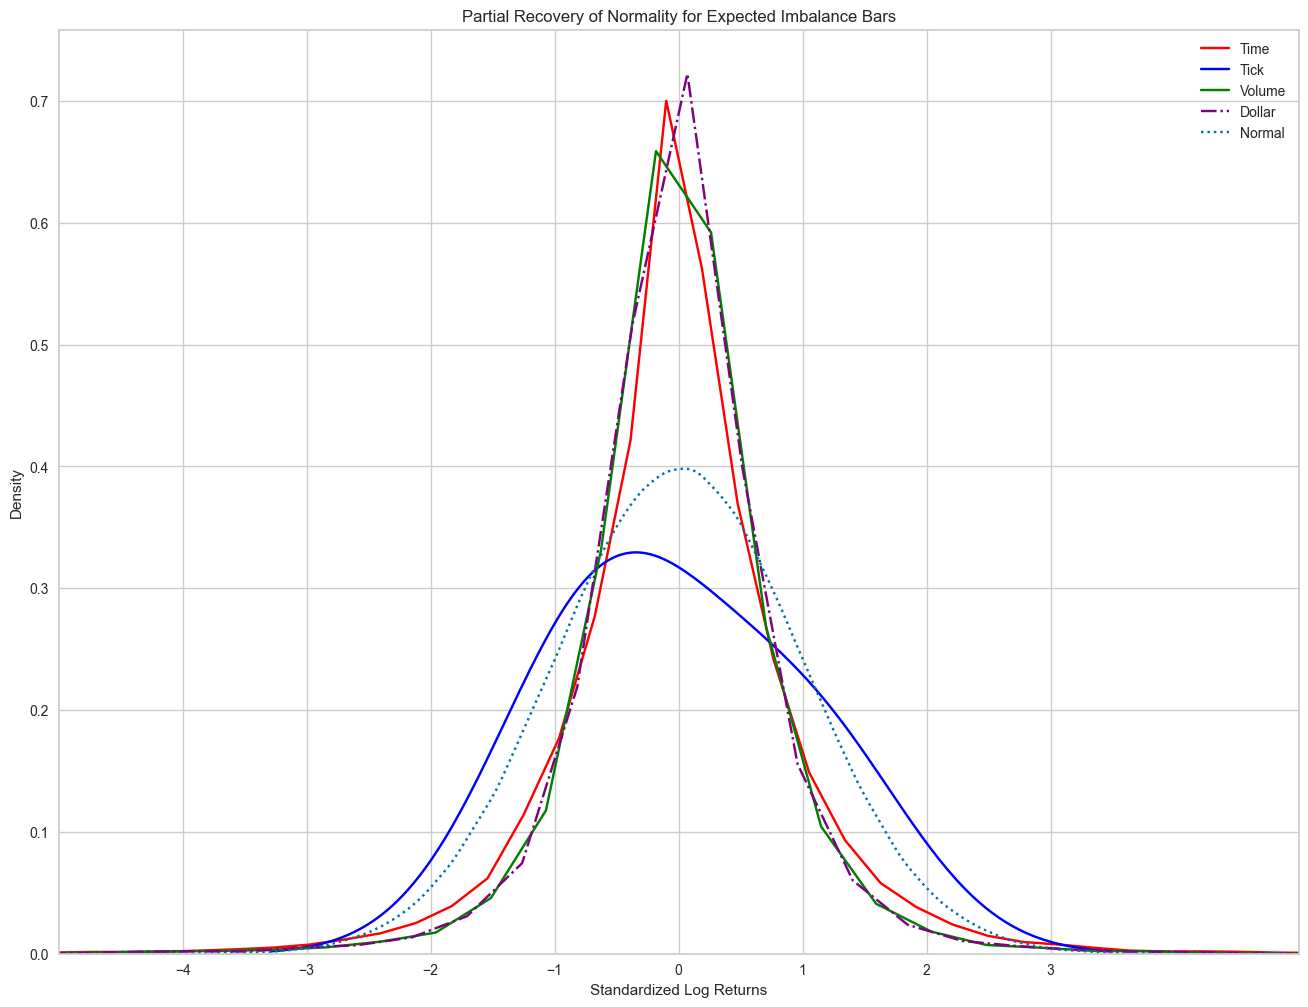

In [38]:
#Distribution Plot
plt.figure(figsize=(16, 12))
sns.kdeplot(time_standard, label="Time", color="red")
sns.kdeplot(EIB_tick_standard, label="Tick", color="blue")
sns.kdeplot(EIB_volume_standard, label="Volume", color="green")
sns.kdeplot(EIB_dollar_standard, label="Dollar", color="purple", linestyle="-.")
sns.kdeplot(np.random.normal(size=1000000), label="Normal", linestyle="dotted")
plt.xticks(range(-4, +4))

#labels
plt.xlabel("Standardized Log Returns")
plt.ylabel("Density")
plt.title(
    'Partial Recovery of Normality for Expected Imbalance Bars',
    loc='center', 
)
plt.xlim(-5, 5)
plt.legend()
plt.show()

## Run Bars

### Tick Run Bars

In [39]:
tick_run_bars = generate_info_driven_bars(sampling_method='expected_tick_run_bars',
                                      df_sample=df_riskAI,
                                      db_best_params=reloaded_db_resampling_params)
tick_run_bars

Processing batch 0 with size 39167


,Date Time,Tick Number,Open,High,Low,Close,Cumulative Volume,Cumulative Buy Volume,Cumulative Sell Volume,Cumulative Ticks,Cumulative Dollar Value,Threshold
0,2025-08-19 01:55:34.812659+00:00,1633,118251.351562,118316.007812,114860.632812,115741.523438,4374.040214,1811.463777,2562.576437,1633,5.102936e+08,832.481481


### Volume Run Bars

In [40]:


volume_run_bars = generate_info_driven_bars(sampling_method='expected_volume_run_bars',
                                      df_sample=df_riskAI,
                                      db_best_params=reloaded_db_resampling_params)
volume_run_bars

Processing batch 0 with size 39167


,Date Time,Tick Number,Open,High,Low,Close,Cumulative Volume,Cumulative Buy Volume,Cumulative Sell Volume,Cumulative Ticks,Cumulative Dollar Value,Threshold
0,2025-08-17 20:49:58.362654+00:00,305,118251.351562,118316.007812,117333.96875,117676.000000,1308.381860,473.09456,835.287300,305,1.540703e+08,832.481481
1,2025-08-23 09:52:21.302784+00:00,7866,117702.890625,117988.070312,111700.00000,115699.992188,40952.502876,20629.74465,20322.758226,7561,4.690468e+09,20615.000000


### Dollar Run Bars

In [41]:
dollar_run_bars = generate_info_driven_bars(sampling_method='expected_dollar_run_bars',
                                      df_sample=df_riskAI,
                                      db_best_params=reloaded_db_resampling_params)
dollar_run_bars

Processing batch 0 with size 39167


,Date Time,Tick Number,Open,High,Low,Close,Cumulative Volume,Cumulative Buy Volume,Cumulative Sell Volume,Cumulative Ticks,Cumulative Dollar Value,Threshold
0,2025-08-17 16:11:48.402662+00:00,27,118251.351562,118316.007812,118211.328125,118285.023438,82.027011,36.479390,45.547621,27,9.700451e+06,2.489597e+06
1,2025-08-17 16:15:48.562648+00:00,31,118275.000000,118275.000000,118053.992188,118053.992188,52.606911,0.000000,52.606911,4,6.213689e+06,5.170702e+06
2,2025-08-17 16:52:49.802656+00:00,68,117967.101562,118194.601562,117843.476562,117843.476562,226.098762,69.130690,156.968071,37,2.667394e+07,1.054432e+07
3,2025-08-17 17:48:51.862303+00:00,124,117759.992188,117934.820312,117681.539062,117911.218750,237.610249,86.876599,150.733650,56,2.798935e+07,1.720419e+07
4,2025-08-17 18:55:54.282654+00:00,191,117894.890625,117947.968750,117333.968750,117333.968750,294.689649,51.426040,243.263608,67,3.465116e+07,1.422784e+07
...,...,...,...,...,...,...,...,...,...,...,...,...
5863,2025-09-14 01:02:36.302922+00:00,38997,115960.953125,116000.000000,115768.750000,115768.750000,106.375370,45.379670,60.995700,58,1.233072e+07,5.660320e+06
5864,2025-09-14 01:52:38.122856+00:00,39047,115810.718750,115990.203125,115752.500000,115990.203125,108.018850,59.987320,48.031530,50,1.251360e+07,6.897869e+06
5865,2025-09-14 02:09:38.743420+00:00,39064,115987.648438,116024.992188,115938.109375,116024.992188,76.362630,60.111730,16.250900,17,8.856836e+06,6.733340e+06
5866,2025-09-14 02:42:39.962679+00:00,39097,116032.742188,116108.992188,115781.039062,115821.976562,92.122500,39.376660,52.745840,33,1.068198e+07,6.072700e+06


### Statistical Test

#### Log Return

In [42]:
tick_run_bars_returns = log_return(tick_run_bars['Close'])
volume_run_bars_returns = log_return(volume_run_bars['Close'])
dollar_run_bars_returns = log_return(dollar_run_bars['Close'])

####  Jarque–Bera test statistic 

In [44]:
print("Jarque-Bera test statistic for time returns:", int(stats.jarque_bera(time_returns)[0]))
#print("Jarque-Bera test statistic for tick run bars returns:", int(stats.jarque_bera(tick_run_bars_returns)[0]))
#print("Jarque-Bera test statistic for volume run bars returns:", int(stats.jarque_bera(volume_run_bars_returns)[0]))
print("Jarque-Bera test statistic for dollar run bars returns:", int(stats.jarque_bera(dollar_run_bars_returns)[0]))

Jarque-Bera test statistic for time returns: 8651820
Jarque-Bera test statistic for dollar run bars returns: 226133


#### Shapiro-Wilk Test

In [45]:
print("Shapiro-Wilk test statistic for time returns:", stats.shapiro(time_returns))
#print("Shapiro-Wilk test statistic for tick run bars returns:", stats.shapiro(tick_run_bars_returns))
#print("Shapiro-Wilk test statistic for volume run bars returns:", stats.shapiro(volume_run_bars_returns))
print("Shapiro-Wilk test statistic for dollar run bars returns:", stats.shapiro(dollar_run_bars_returns))

Shapiro-Wilk test statistic for time returns: ShapiroResult(statistic=0.8621538877487183, pvalue=0.0)
Shapiro-Wilk test statistic for dollar run bars returns: ShapiroResult(statistic=0.8034646511077881, pvalue=0.0)


#### Kernel Density Estimate (KDE) plot

In [ ]:
#Standardize Data 
tick_run_bars_standard = (tick_run_bars_returns - tick_run_bars_returns.mean()) / tick_run_bars_returns.std()
volume_run_bars_standard = (volume_run_bars_returns  - volume_run_bars_returns.mean()) / volume_run_bars_returns.std()
dollar_run_bars_standard = (dollar_run_bars_returns - dollar_run_bars_returns.mean()) / dollar_run_bars_returns.std()

In [ ]:
#Distribution Plot
plt.figure(figsize=(16, 12))
sns.kdeplot(time_standard, label="Time", color="red")
sns.kdeplot(tick_run_bars_standard, label="Tick", color="blue")
sns.kdeplot(volume_run_bars_standard, label="Volume", color="green")
sns.kdeplot(dollar_run_bars_standard , label="Dollar", color="purple", linestyle="-.")
sns.kdeplot(np.random.normal(size=1000000), label="Normal", linestyle="dotted")
plt.xticks(range(-4, +4))

#labels
plt.xlabel("Standardized Log Returns")
plt.ylabel("Density")
plt.title(
    'Partial Recovery of Normality for Run Bars',
    loc='center', 
)
plt.xlim(-5, 5)
plt.legend()
plt.show()

# Additional Features

In [ ]:
def grouped_features(raw_df, resumpling_df, feature_name, agg_func=np.sum):
    """
    Aggregate a feature between Tick Number ranges using a specified aggregation function.

    Parameters
    ----------
    raw_df : pd.DataFrame
        Full DataFrame with tick-by-tick data.
    resumpling_df : pd.DataFrame
        DataFrame with "Tick Number" boundaries (breakpoints).
    feature_name : str
        Column name in raw_df to aggregate (e.g., "ohlc_trades").
    agg_func : function, default=np.sum
        Aggregation function (e.g., np.sum, np.mean, np.max).

    Returns
    -------
    pd.DataFrame
        resumpling_df with the aggregated feature filled.
    """

    resumpling_df[feature_name] = np.nan  

    m = raw_df[feature_name]
    idx_list = resumpling_df.index.astype(int).to_list()

    if idx_list:
        idx_start = idx_list[0]
        idx_end = idx_list[0] + 1
        resumpling_df.loc[idx_start, feature_name] = agg_func(m.iloc[0:idx_end])

    for start, end in zip(idx_list, idx_list[1:]):
        resumpling_df.loc[end, feature_name] = agg_func(m.iloc[start:(end+1)])

    return resumpling_df

def last_state(raw_df,resumpling_df, feature_name):
    """
    Align the latest state of a feature from the raw dataframe
    onto the resampled dataframe at matching indices.

    Parameters
    ----------
    raw_df : pandas.DataFrame
        Original/raw dataset containing the feature of interest.
    resampling_df : pandas.DataFrame
        Resampled dataset whose index is aligned to raw_df.
    feature_name : str
        Column name (feature) to propagate from raw_df to resampling_df.

    Returns
    -------
    pandas.DataFrame
        Updated resampling_df with a new column `feature_name`
        containing the values from raw_df at matching indices. 

    """

    resumpling_df[feature_name] = np.nan  
    idx_list = resumpling_df.index.to_list()
    for i in idx_list:
        resumpling_df.loc[i,feature_name] = raw_df[feature_name][i]
    return resumpling_df

def price_vwap(raw_df, resumpling_df, feature_name, vol_colum_name ='ohlc_volume'):
    """
    Compute VWAP (Volume-Weighted Average Price) for each resampled bar.

    Parameters
    ----------
    raw_df : pandas.DataFrame
        Original dataframe with price and volume data.
    resampling_df : pandas.DataFrame
        Resampled dataframe that defines the bar boundaries (by index).
    feature_name : str
        Column name in raw_df containing prices to weight.
    vol_column_name : str, default="ohlc_volume"
        Column name in raw_df containing volume weights.

    Returns
    -------
    pandas.DataFrame
        Updated resampling_df with an extra column containing VWAP values
        for each resampled interval.
    """
    
    resumpling_df[feature_name] = np.nan  

    m = raw_df[feature_name]
    vol = raw_df[vol_colum_name]

    idx_list = resumpling_df.index.astype(int).to_list()

    if idx_list:
        idx_start = idx_list[0]
        idx_end = idx_list[0] + 1

        resumpling_df.loc[idx_start, feature_name] = np.average(m[0:idx_end], weights=vol[0:idx_end])

    for start, end in zip(idx_list, idx_list[1:]):
        resumpling_df.loc[end, feature_name] = np.average(m[start:(end+1)], weights=vol[start:(end+1)])

    return resumpling_df

In [ ]:
def aggregate_features(input_df, sampling_df):

    """
    Aggregate raw features into resampled bars using different strategies.

    Parameters
    ----------
    input_df : pandas.DataFrame
        Raw tick-level dataframe containing all features.
    sampling_df : pandas.DataFrame
        DataFrame with resampled bar boundaries.
        Must contain a 'Tick Number' column to align with input_df.

    Returns
    -------
    pandas.DataFrame
        Updated sampling_df containing aggregated features.
    """

    sampling_df =sampling_df.set_index("Tick Number")

    vol_sum = ['ohlc_trades','ohlc_taker_base','ohlc_taker_quote',
            'tr_volume_base','tr_volume_quote']

    last_states = ['l1_bid','l1_ask','l1_mid','l1_spread',
                'l1_bid_qty','l1_ask_qty','l1_imbalance',
                'l2_bid_depth','l2_ask_depth','l2_depth_asymmetry',
                'l2_bid_vwap','l2_ask_vwap','l2_bid_slope','l2_ask_slope',
                'spot_price','perp_mark_price','basis_abs','basis_pct',
                'funding_rate','next_funding_time_ms']

    mean_bar= ['tr_buy_sell_imbalance']

    weighted_mean = ['tr_vwap']

    #total
    for i in vol_sum:
        sampling_df  = grouped_features(raw_df=input_df, 
                                        resumpling_df=sampling_df , 
                                        feature_name=i, 
                                        agg_func=np.sum)
    #last value
    for j in last_states:
        sampling_df  = last_state(raw_df=input_df,
                                    resumpling_df=sampling_df ,
                                    feature_name=j)
    #average value   
    for k in mean_bar:
        sampling_df  = grouped_features(raw_df=input_df, 
                                        resumpling_df=sampling_df , 
                                        feature_name=k, 
                                        agg_func=np.mean)
    #weighted average
    for _ in weighted_mean:
        sampling_df  = price_vwap(raw_df=input_df, 
                                    resumpling_df=sampling_df , 
                                    feature_name= _,
                                    vol_colum_name ='ohlc_volume')
        
    return sampling_df

In [ ]:
df_features = aggregate_features(input_df=df, sampling_df=dollar_run_bars)
df_features